## 1. Setup & Preprocessing
a. Load GLOBEM Dataset <br>
Assumption: Provided in CSV format.


Problem Statement in more clear format adding more details.
Follow the exact format give by Greate learning in same order.

Data collection website referernce.
Details of data in 1-2 slides
Define IQR
in the format of Research Question

In [79]:
import pandas as pd
import numpy as np

In [80]:
#Data Path
DATA_DIR = '/Volumes/SanDisk/MyData/WALSHAIMl/WalshAIML/Capstone/GlobemDataSet/GLOBEM-main/data_raw/'
#DATA_SETS = ['INS-W-sample_1','INS-W-sample_2','INS-W-sample_3','INS-W-sample_4']
DATA_SETS = ['INS-W-sample_1']

In [81]:
#Load features and depression scores
features = pd.read_csv(DATA_DIR+ DATA_SETS[0] + '/FeatureData/rapids.csv', low_memory=False)
labels = pd.read_csv(DATA_DIR+ DATA_SETS[0] + '/SurveyData/dep_weekly.csv')

In [82]:
#Merge on [pid, date]
data = pd.merge(features, labels[['pid', 'date', 'dep']], on=['pid', 'date'], how='inner')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Columns: 5511 entries, pid to dep
dtypes: bool(1), float64(3813), object(1697)
memory usage: 1.3+ MB


## Step 2: Normalize Features (Per User)

User-level normalization is the process of transforming each user’s time-series data relative to their own historical baseline, not the entire dataset.

#### Motivation:
- Different users have different natural behaviors.
- One person might sleep 9 hours, another 6 hours — both are normal for them.
- Applying global normalization would treat this variance as noise.
- Goal: Detect deviations from personal norms, not population norms.

In [83]:
def normalize_per_user(df, user_col='pid', feature_cols=[]):
    norm_cols = {}
    for col in feature_cols:
        col_norm = df.groupby(user_col)[col].transform(
            lambda x: (x - x.median()) / (x.quantile(0.95) - x.quantile(0.05) + 1e-6)
        )
        norm_cols[col + '_norm'] = col_norm

    # Create a single new DataFrame and concatenate
    norm_df = pd.DataFrame(norm_cols)
    df = pd.concat([df.reset_index(drop=True), norm_df], axis=1)

    return df

In [84]:
# Parse features to normalize (excluding discretized or already normalized)
feature_cols = [col for col in data.columns if ':' in col and '_norm' not in col and '_dis' not in col]

In [85]:
 # Normalize
df = normalize_per_user(data, user_col='pid', feature_cols=feature_cols)

In [86]:
norm_feature_cols = [f + '_norm' for f in feature_cols]
print(len(norm_feature_cols))

1791


A rolling window is a technique where you take overlapping fixed-size segments from a time-series to analyze local temporal patterns.

We are working with daily passive behavioral data for each user. Instead of modeling entire time-series as a whole:
- Extract small chunks (e.g., 7 days at a time)
- Move the window forward day-by-day (or by custom steps)
- Label each window with a mood score (e.g., PHQ-4) on the last day

In [87]:
def create_rolling_windows(df, user_col='pid', window_size=2, step_size=1, feature_cols=None, label_col='dep'):
    X, y, users = [], [], []
    for pid, group in df.groupby(user_col):
        group = group.sort_values('date')
        if len(group) < window_size:
            continue
        for start in range(0, len(group) - window_size + 1, step_size):
            window = group.iloc[start:start+window_size]
            if window[label_col].isnull().any():
                continue
            X.append(window[feature_cols].values)
            y.append(window[label_col].iloc[-1])
            users.append(pid)
    return np.array(X), np.array(y), np.array(users)

## Step 3: Hierarchical Temporal Contrastive Learning (HTCL)
**Hierarchical Temporal Contrastive Learning (HTCL)** is a deep learning framework designed to learn robust and personalized representations of sequential (temporal) data — particularly for behavioral modeling tasks like depression detection from smartphone-based passive sensing.

Hierarchical Temporal Contrastive Learning is a learning paradigm that uses contrastive loss at multiple temporal resolutions (hierarchies) to train models to differentiate between:
- Semantically similar sequences (e.g., the same user under similar mental states) and
- Semantically different sequences (e.g., different users or opposite mental states),
<br>
in order to learn temporally-aware, user-sensitive embeddings for downstream tasks like classification or regression.

**Key Concepts** <br>
1. Contrastive Learning
- Learns by comparing triplets: (anchor, positive, negative)
- Goal: bring anchor ↔ positive closer in latent space, and push anchor ↔ negative further apart
- Used without explicit supervision (e.g., PHQ scores may not be needed during representation learning)
2. Temporal
- Input data is sequential, e.g., 7-day behavior windows
- Patterns like sleep, activity, and phone usage evolve over time
- Model learns from temporal dependencies
3. Hierarchical
Learns from multiple temporal levels:
- Short-term windows: daily or weekly patterns
- Long-term context: across months or individuals
- Contrastive objectives are applied at different levels:
    - Intra-user contrast: different time windows of the same user
    - Inter-user contrast: compare across different users



In [88]:
# Rolling windows
X, y, users = create_rolling_windows(df, feature_cols=norm_feature_cols)

In [89]:
print(X.shape, y.shape, users)

(20, 2, 1791) (20,) ['INS-W_004' 'INS-W_004' 'INS-W_045' 'INS-W_045' 'INS-W_049' 'INS-W_049'
 'INS-W_052' 'INS-W_052' 'INS-W_086' 'INS-W_086' 'INS-W_118' 'INS-W_118'
 'INS-W_157' 'INS-W_157' 'INS-W_162' 'INS-W_162' 'INS-W_165' 'INS-W_165'
 'INS-W_178' 'INS-W_178']


The Transformer Encoder is a neural network architecture designed to handle sequential data, like: <br>
- Time-series (e.g., 7-day windows of behavior)
- Text (as in NLP)
- Sensor readings over time (as in your GLOBEM dataset)
<br>
###
Originally introduced in the "Attention is All You Need" paper (Vaswani et al., 2017), the Transformer replaces traditional RNNs (like LSTMs) with attention mechanisms, which are faster, more parallelizable, and better at modeling long-term dependencies.

| **Need**  | 	**Transformer Role**                         |
|-----------|-----------------------------------------------|
|Capture patterns over 7-day behavior windows | 	Attends to every day in the window           |
|Weigh importance of different days' behavior | 	Self-attention dynamically scores time steps |
|Model complex dependencies between signals	| Learns how sleep, activity, phone use relate  |
|Handle variable temporal relevance	| Not all days contribute equally to label      |

In the context of depression detection from time-series data:
| **Component**          | **Function**                                                                 |
|------------------------|------------------------------------------------------------------------------|
| Input Sequence         | A 7-day window of normalized behavioral features per user                    |
| Input dim            | `(batch_size, 7, input_dim)`                                                 |
| Linear Embedding       | Projects raw input features into a higher-dimensional latent space           |
| Positional Encoding    | Adds day-wise order info to each time step (since Transformers are orderless)|
| Multi-Head Attention   | Learns dependencies between all days in the sequence                         |
| Feed-Forward Layer     | Applies nonlinear transformation to each time step                           |
| Encoder Layer Stack    | Multiple layers of attention + feed-forward blocks                           |
| Output Sequence        | Contextualized representation of each day in the window                      |
| Output Shape           | `(batch_size, 7, model_dim)`                                                 |
| Usage in Model         | Final day’s output (e.g., `x[:, -1, :]`) is passed to classification layers  |


In [90]:
import torch
import torch.nn as nn

class TransformerEncoder(nn.Module):
    def __init__(self, input_dim, model_dim, nhead, num_layers, dropout=0.1):
        super().__init__()
        self.embedding = nn.Linear(input_dim, model_dim)
        self.pos_encoder = nn.Parameter(torch.randn(100, model_dim))  # Up to 100-day sequences
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):  # (B, T, F)
        x = self.embedding(x) + self.pos_encoder[:x.size(1)]
        x = x.permute(1, 0, 2)  # (T, B, F)
        return self.transformer(x).permute(1, 0, 2)  # (B, T, F)


The Triplet Loss is central to your temporal contrastive learning approach.
It's used to learn better representations by enforcing that: <br>

**“Samples from the same user and mood state are closer together than samples from different users or mood states.”**

Triplet Loss compares:
- Anchor: a sample (e.g., a 7-day window)
- Positive: a sample similar to anchor (same user or same label)
- Negative: a dissimilar sample (different user or opposite label)

| **Term**       | **Meaning**                                                                 |
|----------------|------------------------------------------------------------------------------|
| Anchor         | Input window to be learned                                                  |
| Positive       | Similar window (same user/label)                                            |
| Negative       | Dissimilar window (different user or label)                                 |
| Distance       | Cosine or Euclidean (usually cosine in behavior models)                     |
| Margin         | Minimum gap enforced between positive and negative pairs (e.g., 0.2)        |
| Loss Goal      | Push anchor closer to positive, farther from negative                       |
| Use Case       | Self-supervised representation learning for personalized behavior modeling  |



In [91]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.loss_fn = nn.TripletMarginLoss(margin=margin, p=2)

    def forward(self, anchor, positive, negative):
        return self.loss_fn(anchor, positive, negative)


The ContextDecoder is a neural module that transforms contextual metadata (e.g., "is weekend", "is during COVID", etc.) into a vector representation that can be fused with the behavior sequence encoding.
**Human behavior is context-dependent — the same sleep pattern on a Monday vs. Saturday may mean different things.**

|**Component**|**Meaning**|
|--------|---------|
|Input	| A vector like [0, 1, 1] → weekend, COVID, holiday|
|Output	| A latent vector like [0.3, -0.5, 1.2, ...] |
| Role	| Provides context-aware information to the model |

In [92]:
class ContextDecoder(nn.Module):
    def __init__(self, context_dim, model_dim):
        super().__init__()
        self.embedding = nn.Embedding(context_dim, model_dim)

    def forward(self, context_ids):  # (B, C)
        return self.embedding(context_ids)  # (B, C, D)


The PersonalizedAdapter is a learnable transformation layer designed to personalize the model’s behavior to individual users. <br>

In depression detection: <br>
Each person has different baselines and behavioral patterns. <br>
A model trained globally might miss subtle personal signals. <br>
The PersonalizedAdapter helps tune the shared model’s outputs to better fit an individual user. <br>

Why It Helps in Depression Detection

|**Problem**|**Adapter Solution**|
|-------|--------|
|One model can't fit all users|	Learns user-specific representation shift|
|Subtle differences ignored|	Emphasizes deviations based on personal patterns|
|Context alone is not enough|	Personal embedding + context improves generalization|


In [93]:
#This is a parameterized neural module that learns a transformation of the input representation — it's essentially a bottleneck projection + expansion, applied identically to all samples.
#This design is commonly called a "bottleneck adapter" — it's popular in NLP models (like BERT adapters) and meta-learning setups.
#It is helpful in
## Keeps parameter count low
## Allows quick adaptation with few gradients
## Prevents overfitting by acting like a regularized attention shift

class PersonalizedAdapter(nn.Module):
    def __init__(self, model_dim, bottleneck_dim):
        super().__init__()
        self.adapter = nn.Sequential(
            nn.Linear(model_dim, bottleneck_dim),  #shrink
            nn.ReLU(),                             #non linearity
            nn.Linear(bottleneck_dim, model_dim)   #expand
        )

    def forward(self, x):
        return self.adapter(x)

This is a simple linear classifier that takes a feature vector (e.g., from your Transformer + context + adapter) and outputs logits for binary classification — predicting:
- Class 0: Non-depressed
- Class 1: Depressed

In [94]:
class DepressionClassifier(nn.Module):
    def __init__(self, model_dim):
        super().__init__()
        self.classifier = nn.Linear(model_dim, 2)

    def forward(self, x):
        return self.classifier(x)

### Full Pipeline
- Sequence of user behavior → encoded via Transformer
- Context + personalization → added via adapters
- Resulting vector → fed to this DepressionClassifier
- Outputs logits → passed to loss or softmax

In [95]:
class DepressionDetectionModel(nn.Module):
    def __init__(self, input_dim, context_dim, model_dim, bottleneck_dim, nhead=2, num_layers=2):
        super().__init__()
        self.encoder = TransformerEncoder(input_dim, model_dim, nhead, num_layers)
        self.context_decoder = ContextDecoder(context_dim, model_dim)
        self.adapter = PersonalizedAdapter(model_dim, bottleneck_dim)
        self.classifier = DepressionClassifier(model_dim)

    def forward(self, x, context_ids):
        encoded_seq = self.encoder(x)                  # (B, T, D)
        sequence_repr = encoded_seq[:, -1, :]          # (B, D), last token

        context_repr = self.context_decoder(context_ids)  # (B, D)
        fused = sequence_repr + context_repr            # (B, D)

        personalized = self.adapter(fused)              # (B, D)
        logits = self.classifier(personalized)          # (B, 2)
        return logits

This is a standard PyTorch training function that:

- Takes a model, dataloader, optimizer, and number of epochs
- Runs forward and backward passes
- Updates weights using classification loss
- Tracks and prints the average loss per epoch

In [96]:
import torch
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def train(model, dataloader, optimizer, epochs):
    model = model.to(device)
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for x, context_ids, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            context_ids = context_ids.to(device)

            # Forward pass
            logits = model(x, context_ids)

            # Classification loss
            loss = F.cross_entropy(logits, y)
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / len(dataloader):.4f}")


Using device: cpu


In [97]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Convert to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)     # (N, 7, D)
y_tensor = torch.tensor(y, dtype=torch.long)        # classification (0/1)

print(f"Is NAN exist {torch.isnan(X_tensor).any()}")   # True → problem
print(f"Is INF exist {torch.isinf(X_tensor).any()}")   # True → problem
X_tensor[torch.isnan(X_tensor)] = 0.0
X_tensor[torch.isinf(X_tensor)] = 0.0

print(f"Unquie Y in tensor {torch.unique(y_tensor)}")  # Should be [0, 1]

context_ids_tensor = torch.zeros_like(y_tensor)     # placeholder for now

# Dataset & DataLoader
dataset = TensorDataset(X_tensor, context_ids_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


Is NAN exist True
Is INF exist False
Unquie Y in tensor tensor([0, 1])


In [98]:
model = DepressionDetectionModel(
    input_dim=X.shape[2],       # number of normalized features per day
    context_dim=10,             # number of context tokens (e.g., weekend, COVID, etc.)
    model_dim=128,
    bottleneck_dim=32,
    nhead=4,
    num_layers=2
)

In [99]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
train(model, dataloader, optimizer, epochs=10)

Epoch 1/10 - Loss: 0.6961
Epoch 2/10 - Loss: 0.6832
Epoch 3/10 - Loss: 0.6822
Epoch 4/10 - Loss: 0.6808
Epoch 5/10 - Loss: 0.6755
Epoch 6/10 - Loss: 0.6544
Epoch 7/10 - Loss: 0.6512
Epoch 8/10 - Loss: 0.6334
Epoch 9/10 - Loss: 0.6180
Epoch 10/10 - Loss: 0.6098


In [100]:
from sklearn.metrics import classification_report

model.eval()
with torch.no_grad():
    y_pred = model(X_tensor.to(device), context_ids_tensor.to(device)).argmax(dim=1).cpu()
    print(classification_report(y_tensor, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.78      0.88         9
           1       0.85      1.00      0.92        11

    accuracy                           0.90        20
   macro avg       0.92      0.89      0.90        20
weighted avg       0.92      0.90      0.90        20



In [101]:
import torch
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set model to eval mode
model.eval()
# Forward pass to get predictions and probabilities
with torch.no_grad():
    logits = model(X_tensor.to(device), context_ids_tensor.to(device))
    probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()  # Probability of class 1
    preds = np.round(probs)                                   # Threshold at 0.5
    y_true = y_tensor.numpy()


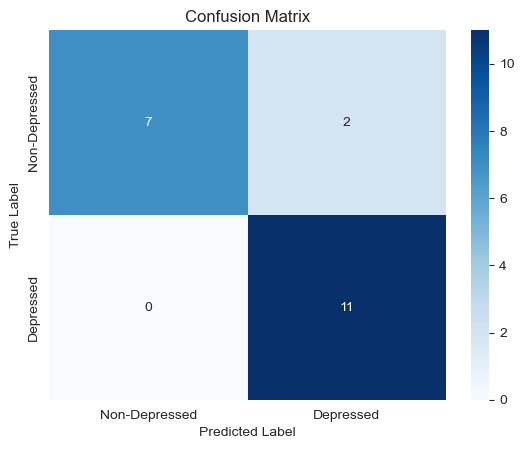

In [102]:
cm = confusion_matrix(y_true, preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Depressed', 'Depressed'],
            yticklabels=['Non-Depressed', 'Depressed'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


Positive <br>
Your model correctly identifies nearly all depressed users Recall = 1.00 <br>
This is critical in depression detection, where false negatives are dangerous. <br>
AUC and F1-score for class 1 are decent, suggesting the model does learn depression-specific patterns. <br>

Need Attention <br>
The model misses most non-depressed users Recall = 0.22 <br>
That means it's over-predicting depression, i.e., it tends to say everyone is depressed unless the signal is clearly otherwise.

Suggestion <br>
- Class Imbalnces or Bias
- Add more data example : Merge INS_W1, INS_W2, INS_w3 etc..

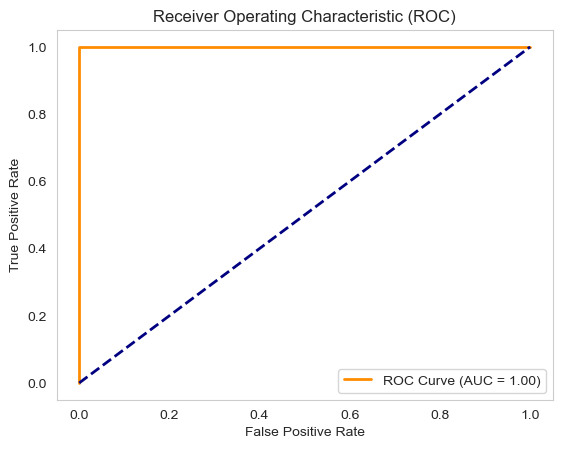

In [103]:
fpr, tpr, thresholds = roc_curve(y_true, probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid()
plt.show()